# Sentiment Analysis of Movie Review  <h3>_(using Stanford Large Movie Review Dataset)_</h3>

Binary Sentiment Classification. <br>
Dataset (25,000 reviews for training, and 25,000 for testing) <br>
**Data Link:** https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz <br>
**CITATION:** _Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)._

`Content Navigation`
- [Data Loading](#Data-Loading)
- [Preprocessing](#Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Extraction](#Feature-Extraction)
- [Model Training and Evaluation](#Model-Training-and-Evaluation)
- [Saving the .pkl of Best Performed Model, & Vectorizer](#Saving-the-.pkl-of-Best-Performed-Model,-&-Vectorizer)

In [37]:
# importing required libraries
import os
import tarfile
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import joblib
from datetime import datetime

In [38]:
# Extracting the zipped files (.tar.gz file)

# with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as tar:
#     tar.extractall(path='extracted_data')

In [39]:
# Download required NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

###  Data Loading

In [40]:
# function for data loading
def load_dataset(directory, max_samples=None):
    data = []
    labels = []
    for label_type in ['pos', 'neg']:
        dir_path = os.path.join(directory, label_type)
        files = os.listdir(dir_path)[:max_samples]
        for file_name in files:
            if file_name.endswith(".txt"):
                try:
                    with open(os.path.join(dir_path, file_name), 'r', encoding='utf-8') as f:
                        review = f.read()
                        data.append(review)
                        labels.append(1 if label_type == 'pos' else 0)
                except Exception as e:
                    print(f"Error reading file {file_name}: {e}")
    return pd.DataFrame({'review': data, 'sentiment': labels})

# Loading the data
train_df = load_dataset('aclImdb/train')
test_df = load_dataset('aclImdb/test')

### Preprocessing

In [41]:
# Text preprocessing
def preprocess_text(text, lemmatizer, stop_words):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r'[^a-z\s]','', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# instantating and assigning lemmatizer, and stopwords
lemmatizer = nltk.stem.WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))

# Applying the text preprocessing function
train_df['cleaned_review'] = train_df['review'].apply(lambda x: preprocess_text(x, lemmatizer, stop_words))
test_df['cleaned_review'] = test_df['review'].apply(lambda x: preprocess_text(x, lemmatizer, stop_words))

In [42]:
# view train_df
train_df.head()

,review,sentiment,cleaned_review
0,Bromwell High is a cartoon comedy. It ran at t...,1,bromwell high cartoon comedy ran time program ...
1,Homelessness (or Houselessness as George Carli...,1,homelessness houselessness george carlin state...
2,Brilliant over-acting by Lesley Ann Warren. Be...,1,brilliant overacting lesley ann warren best dr...
3,This is easily the most underrated film inn th...,1,easily underrated film inn brook cannon sure f...
4,This is not the typical Mel Brooks film. It wa...,1,typical mel brook film much le slapstick movie...


In [43]:
# view test_df
test_df.head()

,review,sentiment,cleaned_review
0,I went and saw this movie last night after bei...,1,went saw movie last night coaxed friend mine i...
1,Actor turned director Bill Paxton follows up h...,1,actor turned director bill paxton follows prom...
2,As a recreational golfer with some knowledge o...,1,recreational golfer knowledge sport history pl...
3,"I saw this film in a sneak preview, and it is ...",1,saw film sneak preview delightful cinematograp...
4,Bill Paxton has taken the true story of the 19...,1,bill paxton taken true story u golf open made ...


In [45]:
# lenght overview
train_df.shape, test_df.shape

((25000, 3), (25000, 3))

###  Exploratory Data Analysis

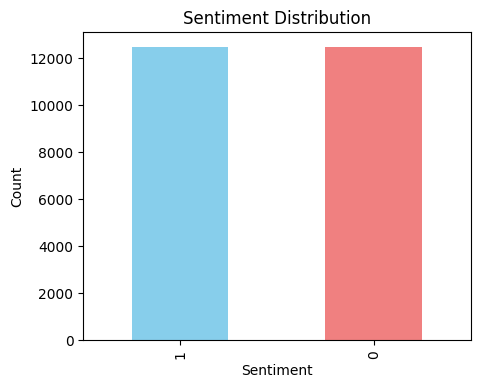

In [46]:
# plotting sentiment distribution
def plot_sentiment_distribution(df):
    plt.figure(figsize=(5, 4))
    df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

# calling the function
plot_sentiment_distribution(train_df)

**Interpretation to the sentiment_distribution:** <br>
-- The reviews are of equal length. <br>
-- does not show extremely short or long reviews, hence devoid of likely ouliers. <br>
-- two peaks (bimodal distribution), which indicate two distinct types of reviews in the dataset.


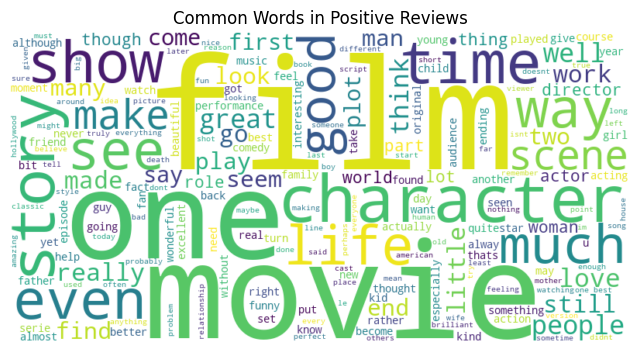

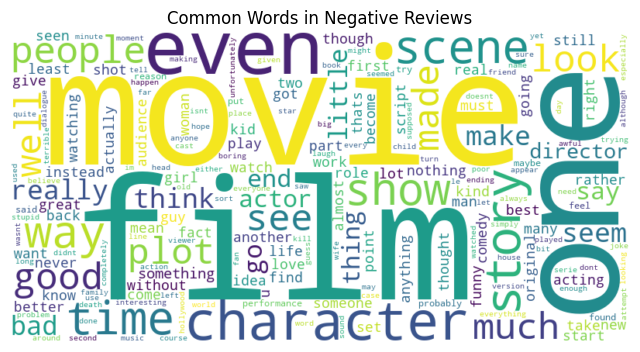

In [47]:
# wordcloud plotting
def plot_wordcloud(df, sentiment):
    text = ' '.join(df[df['sentiment'] == sentiment]['cleaned_review'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Common Words in {'Positive' if sentiment == 1 else 'Negative'} Reviews")
    plt.axis('off')
    plt.show()

# calling the function
plot_wordcloud(train_df, sentiment=1)
plot_wordcloud(train_df, sentiment=0)

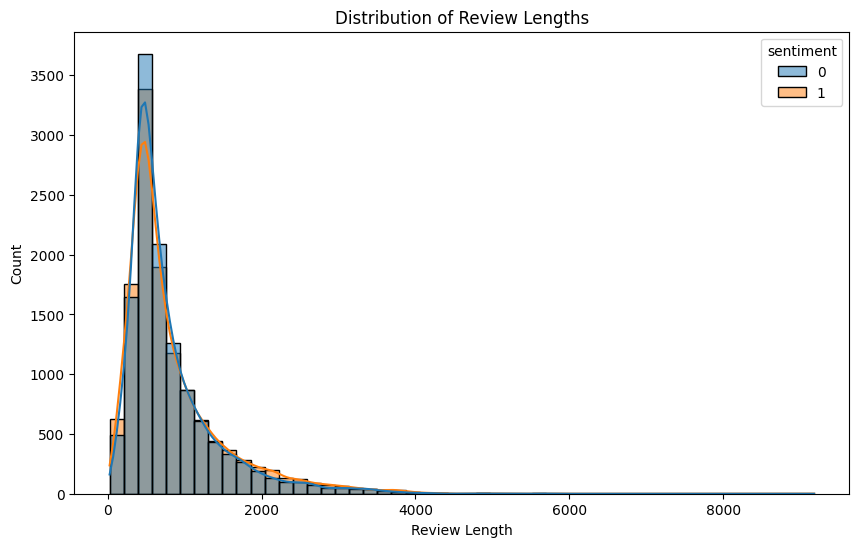

In [48]:
# plotting review length distribution
def plot_review_length_distribution(df):
    plt.figure(figsize=(10, 6))
    df['review_length'] = df['cleaned_review'].apply(len)
    sns.histplot(data=df, x='review_length', hue='sentiment', bins=50, kde=True)
    plt.title('Distribution of Review Lengths')
    plt.xlabel('Review Length')
    plt.ylabel('Count')
    plt.show()

# calling the function
plot_review_length_distribution(train_df)

**Interpretation to the review_length_distribution:** <br>
-- Negative reviews tend to be slightly longer than positive reviews on average. <br>
-- There's a wide range of review lengths for both sentiments. <br>
-- Some very long reviews exist for both sentiments (the long right tails). <br>
-- The majority of reviews fall within a certain length range (the peaks of the curves).


### Feature Extraction

In [49]:
# using TfidfVectorizer for feature extraction
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(train_df['cleaned_review'])
X_test = vectorizer.transform(test_df['cleaned_review'])

### Model Training and Evaluation  


Training Naive Bayes...
Cross-validation scores: [0.8146 0.7954 0.812  0.7994 0.8124]
Mean CV score: 0.8068

Naive Bayes - Test Set Evaluation:
Accuracy: 0.8353
              precision    recall  f1-score   support

           0       0.81      0.87      0.84     12500
           1       0.86      0.80      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



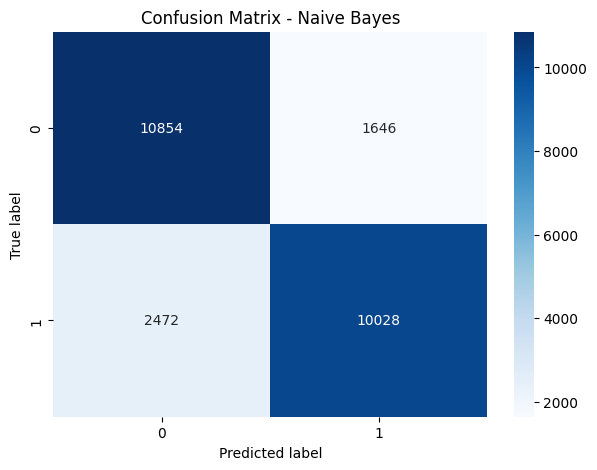


Training Logistic Regression...
Cross-validation scores: [0.866  0.8476 0.8532 0.8562 0.8666]
Mean CV score: 0.8579

Logistic Regression - Test Set Evaluation:
Accuracy: 0.8776
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



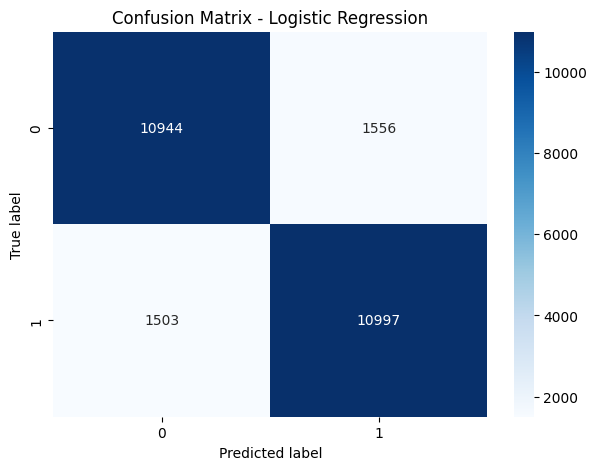

In [50]:
# confusion matrix plotting for evaluation
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


# Model instantiation
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=200)
}

# To keep track of the best model
best_model = None
best_accuracy = 0
best_model_name = ''

# looping through the model
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, train_df['sentiment'])
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train, train_df['sentiment'], cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean():.4f}")
    
    # Evaluation on test set
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(test_df['sentiment'], y_pred)
    print(f"\n{name} - Test Set Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(test_df['sentiment'], y_pred))
    
    # Confusion matrix
    plot_confusion_matrix(test_df['sentiment'], y_pred, name)
    
    # Checking which of the model is the best
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

### Interpretation

The balance between class 0 and class 1 predictions suggests that the Logistic Regression model is not heavily biased toward one class.
The Precision, Recall, and Mean CV score evaluated, showed better performance by the Logistic Regression model.

### Saving the .pkl of Best Performed Model, & Vectorizer

In [51]:
# Saving the best model
#timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(best_model, f'{best_model_name.lower().replace(" ", "_")}_model.pkl') # _model_{timestamp}.pkl'
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

print(f"\nBest model: {best_model_name} with accuracy: {best_accuracy:.4f}")
print(f"Best model saved as: {best_model_name.lower().replace(' ', '_')}_model.pkl")
print("TF-IDF vectorizer saved as: tfidf_vectorizer.pkl")


Best model: Logistic Regression with accuracy: 0.8776
Best model saved as: logistic_regression_model.pkl
TF-IDF vectorizer saved as: tfidf_vectorizer.pkl
